# Gas Damping Forces

`gas_damping_forces` updates orbits with prescribed timescales by directly changing orbital elements after each timestep, based on Dawson et al. 2016.  Outlined in Equation 16 from Dawson et al. 2016, the gas damping timescale $\tau$ is:

$$ \tau= 0.003 d \left(\frac{a}{\text{AU}}\right)^2  \left(\frac{M_\odot}{M_p}\right) \text{yr} \times \left\{
\begin{array}{ll}
      1 & v<c_s \\
      \left(\frac{v}{c_s}\right)^3 & v>c_s, i<c_s/v_K \\
      \left(\frac{v}{c_s}\right)^4 & i>c_s/v_K \\
\end{array} 
\right.  $$

where $d$ is the depletion factor (more on this in a bit); $a$ is the semimajor axis of the body; $M_p$ is the mass of the body; $v=\sqrt{e^2 + i^2}v_K$ is the random (epicyclic) velocity; $v_K=na$ is the Keplerian velocity, where $n$ is the body's mean motion; and $c_s = 1.29 \text{ km/s} \left(\frac{a}{\text{AU}}\right)^{-1/4}$ is the gas sound speed.

Once the gas damping timescale $\tau$ has been calculated, we apply this timescale to both the eccentricity and inclination through the following equations:

$$
\dot{e}/e = -1/\tau
$$

$$
\dot{i}/i = -2/\tau
$$

**Good News**: You don't need to worry about the equations above since `gas_damping_forces` figures out which regime (part of the piecewise function) to use at each timestep for each body in your simulation. 

The only thing you need to define is `gdf_damp_coeff` which corresponds to the depletion factor $d$ in the above equation.

##### So what is the depletion factor $d$?

The depletion factor $d$ is a constant that describes how "depleted" the nebular gas disk is; or, in other words, how much gas has dissipated from a protoplanetary gas disk.

The depletion factor is set such that $d=1$ corresponds to the gas surface density at 1 AU is $\Sigma_g(d=1, a=1\text{ AU}) = 1700 \text{ g cm}^{-2}$.  (This gas density corresponds roughly to the full minimum mass solar nebula).

So, any value of $d>1$ corresponds to a **depletion** in the amount of gas present.

## Let's do a simulation!

We will investigate what happens to an Earth-mass planet in a depleted gas disk with $d=5$.

In [1]:
import rebound
import reboundx
import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline 

In [74]:
def calc_tau(d, m, a, e, i, Mstar=1):
    
    '''
    m: planet mass [M_sun]
    a: semimajor axis [AU]
    e: eccentricity
    i: inclination [radians]
    Mstar: star mass [M_sun]; default=1 Solar Mass
    ''' 
    
    G = 4*np.pi**2  # gravitational constant [AU^3/M_sun/yr^2]
    
    cs = 0.272125 * a**(-1/4)         # gas sound speed; coefficient = 1.29 km/s = 0.272125 AU/yr
    vK = np.sqrt(G * Mstar / a)       # Keplerian velocity
    v = np.sqrt(e**2 + i**2) * vK     # random velocity
    
    tau = 0.003 * d * a**2 * (Mstar/m)
    
    if v<cs:
        return tau
    
    elif v>cs and i<cs/vK:
        tau *= (v/cs)**3
        return tau
    
    elif i>cs/vK:
        tau *= (v/cs)**4
        return tau
    

In [68]:
sim = rebound.Simulation()
e0 = 0.05
inc0 = 5*np.pi/180                        # 5 degrees in radians

sim.add(m=1.)
sim.add(m=3e-6, a=0.1, e=e0, inc=inc0)
sim.move_to_com()                         # Moves to the center of momentum frame
ps = sim.particles

In [69]:
rebx = reboundx.Extras(sim)
gdf = rebx.load_force('gas_damping_forces')
rebx.add_force(gdf)

ps[1].params['gdf_damp_coeff'] = 5

In [70]:
tmax = 2.0e3
Nout = 1000

ecc, inc = np.zeros(Nout), np.zeros(Nout)
times = np.linspace(0., tmax, Nout)
for i, time in enumerate(times):
    # print progress of simulation
    if (i/10)%10==0:
        print(str(round(i/1000*100))+'%', end='    ')
    sim.integrate(time)
    ecc[i] = ps[1].e
    inc[i] = ps[1].inc
    
print('100% - Done!', end='    ')

0%    10%    20%    30%    40%    50%    60%    70%    80%    90%    100% - Done!    

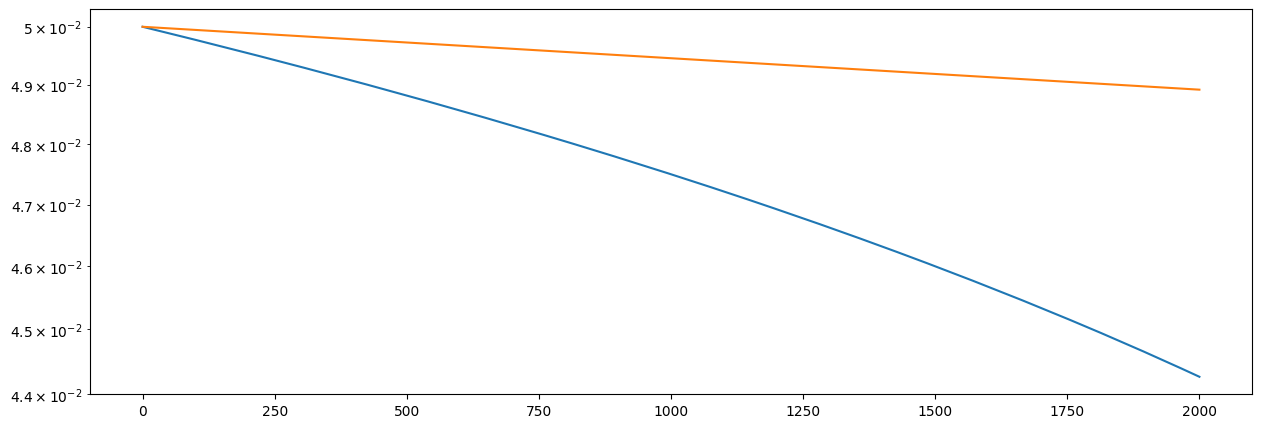

In [75]:
# let's compare how the eccentricity would have changed if the damping timescale was constant
ecc_const_tau = e0*np.exp(-times/(2*np.pi)/calc_tau(d=5, m=3e-6, a=0.1, e=e0, i=inc0))

fig = plt.figure(figsize=(15,5))
plt.plot(times, ecc)
plt.plot(times, ecc_const_tau)
plt.yscale('log')

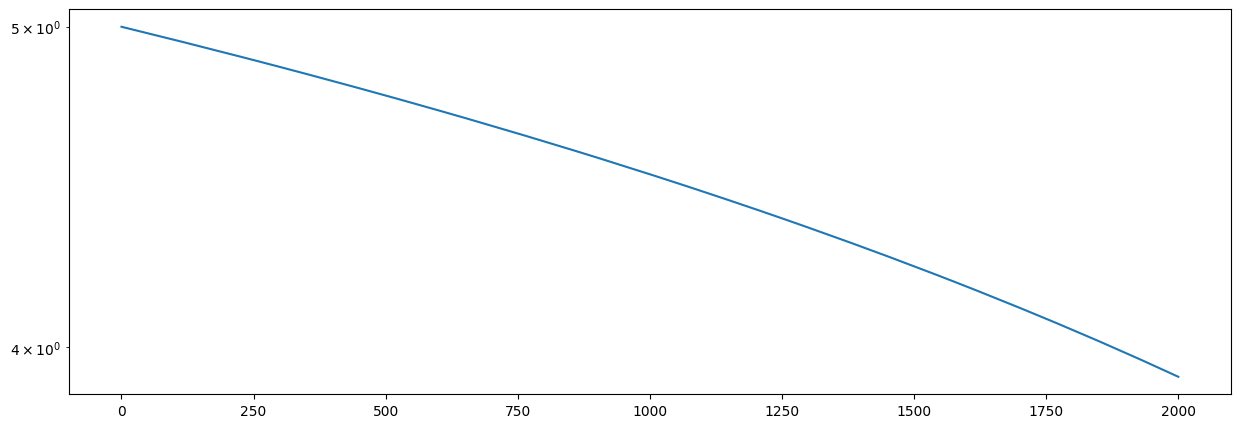

In [73]:


fig = plt.figure(figsize=(15,5))
plt.yscale('log')
plt.plot(times, inc*180/np.pi)
